In [1]:
import time
import gym
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns

#import tensorlayer as tl
#tl.logging.set_verbosity(tl.logging.DEBUG) # 使tensorflow只对debug信息进行输出
import joblib
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

import random 
import math

from pandas import DataFrame
try:
    import cPickle as pickle
except ImportError:
    import _pickle as pickle
import copy
%matplotlib inline
import matplotlib.pyplot as plt

tf.compat.v1.disable_eager_execution()

import tensorflow.compat.v1 as tf 
tf.disable_v2_behavior()
import statistics
pd.options.display.max_rows = 999
import klib

import warnings
warnings.filterwarnings("ignore")

Instructions for updating:
non-resource variables are not supported in the long term


# Data load


In [2]:
dirname = "S_R8/"
mimic_dir = "/public/hanl/jupyter_dir/ir_recommend_v2/04.merge/" + dirname
print(os.listdir(mimic_dir))

df_train = pd.read_csv(mimic_dir + '/train_data.csv')
#df_train.loc[(df_train["reward"]==-40),"reward"] = -100 # 163条
df_val = pd.read_csv(mimic_dir + '/val_data.csv')
df_test = pd.read_csv(mimic_dir + '/test_data.csv')

df_all = pd.read_csv(mimic_dir + '/all_data.csv')
df_all = df_all.sort_values(["traj_id","starttime"])
df_all["last_rate"].fillna(0,inplace=True)

df_train = df_train[df_train["idx"] != max(df_all["idx"])]

df_train.index = pd.RangeIndex(len(df_train.index))
df_val.index = pd.RangeIndex(len(df_val.index))
df_test.index = pd.RangeIndex(len(df_test.index))
print(df_test.shape)

['all_data.csv', 'train_data.csv', 'val_data.csv', 'test_data.csv']
(12, 273)


##  参数修改

In [3]:
save_dir = "./dqn_normal_noterm_R8_v2_t1/"

eval_data = df_train
eval_Q = 'dqn_normal_q_train.p'
eval_ac = 'dqn_normal_actions_train.p'

## result 导入

In [4]:
agent_actions = pickle.load(open(save_dir + eval_ac, "rb" ))
agent_q = pickle.load(open(save_dir + eval_Q, "rb" ))
df= eval_data
print(df.shape)
cols = [ 'traj_id', "stay_id",'starttime', 'endtime', "rate","last_rate", "rate_bin", "reward", "glucose_mean", 'glucose_max', 'glucose_min',"next_glucose_mean",'next_glucose_max', 'next_glucose_min']
df_eval = df[cols]

df_eval_add = pd.concat([df_eval, pd.Series(agent_actions)], axis=1)
df_eval_add = df_eval_add.rename(columns={0:'agent_actions'})
df_eval_add = pd.concat([df_eval_add, pd.Series(agent_q)], axis=1)
df_eval_add = df_eval_add.rename(columns={0:'agent_q'})
df_eval_add.sort_values(by=["traj_id","starttime"]).head(1)

(165793, 273)


,traj_id,stay_id,starttime,endtime,rate,last_rate,rate_bin,reward,glucose_mean,glucose_max,glucose_min,next_glucose_mean,next_glucose_max,next_glucose_min,agent_actions,agent_q
0,1,30001148,544.02,604.02,2.0,2.0,2,5.3125,109.0,109.0,109.0,103.8,109.0,86.0,1,22.380844


In [5]:
infile = "/public/hanl/jupyter_dir/ir_recommend_v2/03.reward/R_decomposition_60m_add.csv"
df = pd.read_csv(infile)
df["starttime"] = pd.to_datetime(df["starttime"])
df["endtime"] = pd.to_datetime(df["endtime"])
df["traj_id"]= df["traj_id"].astype("float64")

# 更改datetime格式为入ICU后的几分钟
datadir = "/public/hanl/jupyter_dir/ir_recommend_v2/00.data/"
file = datadir + "icustays_pat_with_r_interval.csv"
df_icu = pd.read_csv(file)
df_icu["intime"] = pd.to_datetime(df_icu["intime"], format='%d/%m/%Y %H:%M:%S')
df_icu=df_icu.loc[:,["stay_id", "intime"]]

tmp_df = pd.merge(df, df_icu, how="left",on="stay_id")
tmp_df["starttime_m"] = (tmp_df["starttime"] - tmp_df["intime"]).map(lambda x:x/np.timedelta64(1, 'm')).tolist()
tmp_df["endtime_m"] = (tmp_df["endtime"] - tmp_df["intime"]).map(lambda x:x/np.timedelta64(1, 'm')).tolist()
tmp_df = tmp_df.drop(["starttime","endtime","intime"], axis=1)
tmp_df = tmp_df.rename(columns={'starttime_m': 'starttime', "endtime_m":'endtime'})
df = tmp_df
df["starttime"] = round(df["starttime"],2)
df["endtime"] = round(df["endtime"],2)

df = df[~df["reward"].isna()]

In [6]:
df_eval_add2 = pd.merge(df_eval_add, df, how="inner", on=['stay_id', 'traj_id', 'starttime', 'endtime',"reward",'rate'])
df_eval_add2["distance"] = df_eval_add2["rate_bin"] - df_eval_add2["agent_actions"]


print("phy:", df_eval_add2.rate_bin.unique())
print("agent:", df_eval_add2.agent_actions.unique())

phy: [ 2  1  5  6  4  3  8 12  9  7 10 11 14 13  0]
agent: [ 1  3  0  6  4  9  2  7  5 12 10 13  8 14 11]


In [7]:
df_ac_fea = df_eval_add2 
cut_point = [0,70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450,6000]
label_lst = ['0_70', '70_80', '80_90', '90_100', '100_110', '110_120', '120_130', '130_140', '140_150', '150_160', '160_170', '170_180', '180_190', '190_200', '200_210', '210_220', '220_230', '230_240', '240_250', '250_260', '260_270', '270_280', '280_290', '290_300', '300_310', '310_320', '320_330', '330_340', '340_350', '350_360', '360_370', '370_380', '380_390', '390_400', '400_410', '410_420', '420_430', '430_440', '440_450', '450_6000']
max_rate = 2000

rate_bin = {}
tmp_rate = cut_point[0]
cut_point = cut_point[1:]
idx = 0
while tmp_rate <= max_rate:
    last_tmp_rate = tmp_rate
    tmp_rate = cut_point[idx]
    rate_bin[(last_tmp_rate, tmp_rate)] = label_lst[idx]
    idx += 1
print(rate_bin)


rate_bin2 ={}
lst = df_ac_fea["glucose_mean"].unique().tolist()
for i in lst:
    for keys in rate_bin.keys():
        if (i >= keys[0]) & (i<keys[1]):
            rate_bin2[i] = rate_bin[keys]

df_eval_add2["glu_bin"] = df_eval_add2.glucose_mean.map(rate_bin2)


{(0, 70): '0_70', (70, 80): '70_80', (80, 90): '80_90', (90, 100): '90_100', (100, 110): '100_110', (110, 120): '110_120', (120, 130): '120_130', (130, 140): '130_140', (140, 150): '140_150', (150, 160): '150_160', (160, 170): '160_170', (170, 180): '170_180', (180, 190): '180_190', (190, 200): '190_200', (200, 210): '200_210', (210, 220): '210_220', (220, 230): '220_230', (230, 240): '230_240', (240, 250): '240_250', (250, 260): '250_260', (260, 270): '260_270', (270, 280): '270_280', (280, 290): '280_290', (290, 300): '290_300', (300, 310): '300_310', (310, 320): '310_320', (320, 330): '320_330', (330, 340): '330_340', (340, 350): '340_350', (350, 360): '350_360', (360, 370): '360_370', (370, 380): '370_380', (380, 390): '380_390', (390, 400): '390_400', (400, 410): '400_410', (410, 420): '410_420', (420, 430): '420_430', (430, 440): '430_440', (440, 450): '440_450', (450, 6000): '450_6000'}


#  Result1:期望两者分布偏一致
- 前提：两者行为一致时reward更高
- reward大小关系和血糖关系见后面

##  action(agent/real) 分布

Text(0.5, 0, 'rate_bin')

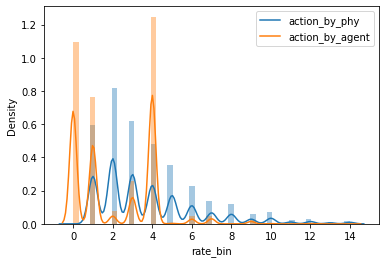

In [8]:
df = df_eval_add2.loc[:,["rate_bin", "agent_actions"]]

sns.distplot(df["rate_bin"])
sns.distplot(df["agent_actions"])
plt.legend(["action_by_phy", "action_by_agent"])
plt.xlabel("rate_bin")

## action(agent/real) 分布

In [9]:
df = df_eval_add2
last_jj = df[df["glu_bin"] == "0_70"]["rate_bin"].value_counts().head(8)
last_jj = last_jj.rename("0_70", inplace=True)
switch = "on"
for i,j in df[df["glu_bin"] != "0_70"].groupby(["glu_bin"]):
    jj = j["rate_bin"].value_counts().head(8)
    jj = jj.rename(i, inplace=True)
    if switch == "on":
        tmp_df = pd.concat([last_jj, jj], axis=1)
        switch = "off"
        continue    
    tmp_df = pd.concat([tmp_df, jj], axis=1)
tmp_df = tmp_df.loc[:,['0_70', '70_80', '80_90', '90_100', '100_110', '110_120', '120_130', '130_140', '140_150',
       '150_160', '160_170', '170_180', '180_190', '190_200', '200_210',
       '210_220', '220_230', '230_240', '240_250', '250_260', '260_270',
       '270_280', '280_290', '290_300', '300_310', '310_320', '320_330',
       '330_340', '340_350', '350_360', '360_370', '370_380', '380_390',
       '390_400', '400_410', '410_420', '420_430', '430_440', '440_450',
       '450_6000']]    
tmp_df = tmp_df.T
tmp_df.style.highlight_max(color = 'lightgreen', axis = 1)

,1,2,3,4,5,6,7,8,9,10,11,12,14
0_70,200.000000,191.000000,111.000000,96.000000,66.000000,26.000000,34.000000,20.000000,nan,nan,nan,nan,nan
70_80,524.000000,428.000000,310.000000,186.000000,137.000000,90.000000,46.000000,37.000000,nan,nan,nan,nan,nan
80_90,1492.000000,1313.000000,797.000000,575.000000,337.000000,206.000000,116.000000,89.000000,nan,nan,nan,nan,nan
90_100,3577.000000,3428.000000,1926.000000,1256.000000,755.000000,459.000000,211.000000,137.000000,nan,nan,nan,nan,nan
100_110,4755.000000,5415.000000,3176.000000,2166.000000,1293.000000,749.000000,381.000000,278.000000,nan,nan,nan,nan,nan
110_120,4622.000000,6328.000000,4074.000000,2691.000000,1659.000000,979.000000,500.000000,355.000000,nan,nan,nan,nan,nan
120_130,3698.000000,5754.000000,4150.000000,3062.000000,1942.000000,1172.000000,637.000000,456.000000,nan,nan,nan,nan,nan
130_140,2733.000000,4691.000000,3755.000000,2992.000000,1844.000000,1186.000000,686.000000,522.000000,nan,nan,nan,nan,nan
140_150,1936.000000,3704.000000,3277.000000,2393.000000,1768.000000,1122.000000,662.000000,498.000000,nan,nan,nan,nan,nan
150_160,1282.000000,2246.000000,2132.000000,1810.000000,1410.000000,954.000000,558.000000,462.000000,nan,nan,nan,nan,nan


In [10]:
df = df_eval_add2
last_jj = df[df["glu_bin"] == "0_70"]["agent_actions"].value_counts().head(8)
last_jj = last_jj.rename("0_70", inplace=True)
switch = "on"
for i,j in df[df["glu_bin"] != "0_70"].groupby(["glu_bin"]):
    jj = j["agent_actions"].value_counts().head(8)
    jj = jj.rename(i, inplace=True)
    if switch == "on":
        tmp_df = pd.concat([last_jj, jj], axis=1)
        switch = "off"
        continue    
    tmp_df = pd.concat([tmp_df, jj], axis=1)
tmp_df = tmp_df.loc[:,['0_70', '70_80', '80_90', '90_100', '100_110', '110_120', '120_130', '130_140', '140_150',
       '150_160', '160_170', '170_180', '180_190', '190_200', '200_210',
       '210_220', '220_230', '230_240', '240_250', '250_260', '260_270',
       '270_280', '280_290', '290_300', '300_310', '310_320', '320_330',
       '330_340', '340_350', '350_360', '360_370', '370_380', '380_390',
       '390_400', '400_410', '410_420', '420_430', '430_440', '440_450',
       '450_6000']]    
tmp_df = tmp_df.T
tmp_df.style.highlight_max(color = 'lightgreen', axis = 1)

,0,1,2,3,4,5,6,7,9,10,12,13
0_70,174.000000,185.000000,6.000000,27.000000,365.000000,6.000000,9.000000,nan,5.000000,nan,nan,nan
70_80,541.000000,383.000000,37.000000,56.000000,749.000000,13.000000,18.000000,nan,11.000000,nan,nan,nan
80_90,1707.000000,801.000000,126.000000,181.000000,2123.000000,18.000000,50.000000,nan,20.000000,nan,nan,nan
90_100,4550.000000,2025.000000,334.000000,441.000000,4389.000000,nan,110.000000,30.000000,40.000000,nan,nan,nan
100_110,7337.000000,3413.000000,486.000000,763.000000,6263.000000,nan,161.000000,33.000000,90.000000,nan,nan,nan
110_120,8464.000000,4148.000000,486.000000,1042.000000,7127.000000,nan,240.000000,48.000000,84.000000,nan,nan,nan
120_130,7642.000000,4493.000000,510.000000,1298.000000,7058.000000,nan,251.000000,90.000000,92.000000,nan,nan,nan
130_140,6063.000000,4396.000000,408.000000,1557.000000,6215.000000,nan,190.000000,108.000000,81.000000,nan,nan,nan
140_150,4450.000000,4125.000000,252.000000,1759.000000,5061.000000,nan,184.000000,110.000000,86.000000,nan,nan,nan
150_160,2834.000000,2868.000000,181.000000,1229.000000,4043.000000,nan,161.000000,112.000000,84.000000,nan,nan,nan


# reward合理性评估

In [11]:
infile = "/public/hanl/jupyter_dir/ir_recommend_v2/03.reward/R_decomposition_60m_add.csv"
df = pd.read_csv(infile)
df["starttime"] = pd.to_datetime(df["starttime"])
df["endtime"] = pd.to_datetime(df["endtime"])
df["traj_id"]= df["traj_id"].astype("float64")
print(df.head(1))

# 更改datetime格式为入ICU后的几分钟
datadir = "/public/hanl/jupyter_dir/ir_recommend_v2/00.data/"
file = datadir + "icustays_pat_with_r_interval.csv"
df_icu = pd.read_csv(file)
df_icu["intime"] = pd.to_datetime(df_icu["intime"], format='%d/%m/%Y %H:%M:%S')
df_icu=df_icu.loc[:,["stay_id", "intime"]]

tmp_df = pd.merge(df, df_icu, how="left",on="stay_id")
tmp_df["starttime_m"] = (tmp_df["starttime"] - tmp_df["intime"]).map(lambda x:x/np.timedelta64(1, 'm')).tolist()
tmp_df["endtime_m"] = (tmp_df["endtime"] - tmp_df["intime"]).map(lambda x:x/np.timedelta64(1, 'm')).tolist()
tmp_df = tmp_df.drop(["starttime","endtime","intime"], axis=1)
tmp_df = tmp_df.rename(columns={'starttime_m': 'starttime', "endtime_m":'endtime'})
df = tmp_df
df["starttime"] = round(df["starttime"],2)
df["endtime"] = round(df["endtime"],2)

df_cut = df.loc[:,['stay_id', 'traj_id','fast_control', 'fast_score',
       'steady_control', 'steady_score', 'steady_type', 'fast_type',
       'control_type', 'starttime', "endtime","reward","rate"]]

tmp_df = df_cut
tmp_df.head(1)

    stay_id  traj_id           starttime             endtime  rate  \
0  30001148      1.0 2156-08-30 20:15:00 2156-08-30 21:15:00   2.0   

  fast_control  fast_score   steady_control  steady_score  reward steady_type  \
0           []         NaN  [[109.0, 86.0]]        5.3125  5.3125          TT   

  fast_type control_type  
0       NaN            S  


,stay_id,traj_id,fast_control,fast_score,steady_control,steady_score,steady_type,fast_type,control_type,starttime,endtime,reward,rate
0,30001148,1.0,[],NaN,"[[109.0, 86.0]]",5.3125,TT,NaN,S,544.02,604.02,5.3125,2.0


In [12]:
df = tmp_df
cut_point = [-40, -35, -30, -25, -20, -15, -10, -5, 0, 5, 10, 15, 21]

max_v = max(df["reward"])
v_bin = {}

tmp_v = cut_point[0]
cut_point = cut_point[1:]
idx = 0
while tmp_v <= max_v:
    last_tmp_v = tmp_v
    tmp_v = cut_point[idx]
    v_bin[(last_tmp_v, tmp_v)] = idx
    idx += 1
print(v_bin)

v_bin2 ={}
lst = df["reward"].unique().tolist()
for i in lst:
    for keys in v_bin.keys():
        if (i >= keys[0]) & (i<keys[1]):
            v_bin2[i] = v_bin[keys]

df["reward_bin"] = df.reward.map(v_bin2)
df = df.sort_values(by=["traj_id", "stay_id", "starttime"])
df.index = pd.RangeIndex(len(df.index))

v_bin_reverse = {}
for i,j in v_bin.items():
    v_bin_reverse[j] = i

{(-40, -35): 0, (-35, -30): 1, (-30, -25): 2, (-25, -20): 3, (-20, -15): 4, (-15, -10): 5, (-10, -5): 6, (-5, 0): 7, (0, 5): 8, (5, 10): 9, (10, 15): 10, (15, 21): 11}


In [13]:
shape_lst = []
HT_lst = []
HL_lst = []
HMH_lst = []
HH_lst = []
TD_lst = []
TT_lst = []
TH_lst = []
TL_lst = []
x_reward = []

type_lst = ['HH', 'HT', "HL", "HMH"]
type2_lst = ['TD', 'TT', 'TH', 'TL']

for i in range(0,12,1):
    x_reward.append(v_bin_reverse[i])
    df_filt = df[df["reward_bin"]==i]
    
    fast_lst = df_filt.fast_type.value_counts().keys().tolist()
    df_tmp = df_filt.fast_type.value_counts()
    
    steady_lst = df_filt.steady_type.value_counts().keys().tolist()
    df_tmp2 = df_filt.steady_type.value_counts()
    
    for type1 in list(set(type_lst).difference(set(fast_lst))):
        df_tmp[type1] =0
    for type2 in list(set(type2_lst).difference(set(steady_lst))):
        df_tmp2[type2] =0
        
    shape_lst.append(df_filt.shape[0])
    HT_lst.append(df_tmp["HT"])
    HL_lst.append(df_tmp["HL"])
    HMH_lst.append(df_tmp["HMH"])
    HH_lst.append(df_tmp["HH"])

    TD_lst.append(df_tmp2["TD"])
    TT_lst.append(df_tmp2["TT"])
    TH_lst.append(df_tmp2["TH"])
    TL_lst.append(df_tmp2["TL"])
  

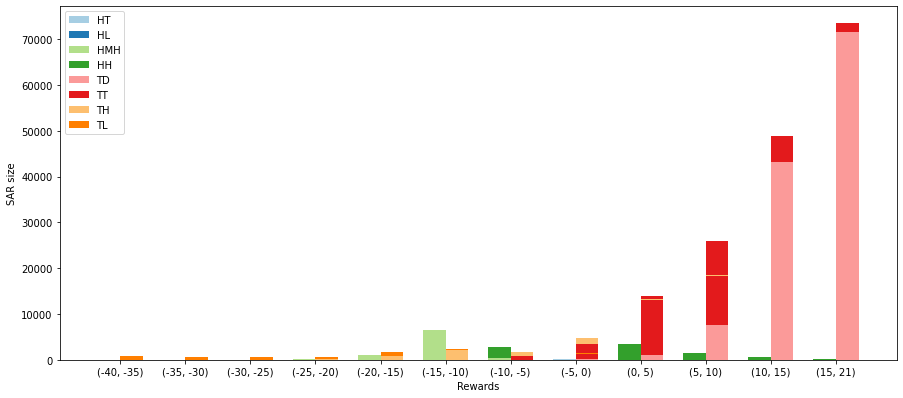

In [14]:
import matplotlib.pyplot as plt
import numpy as np

labels = ['(-40, -35)', "(-35, -30)", "(-30, -25)", "(-25, -20)", "(-20, -15)", "(-15, -10)", "(-10, -5)", "(-5, 0)", "(0, 5)", "(5, 10)", "(10, 15)", "(15, 21)"]
x = np.arange(len(labels))

width = 0.35 
fig, ax = plt.subplots(figsize=(15, 6.5))  
ax.bar(x - width/2, HT_lst, width, color='#a6cee3', label='HT')  
ax.bar(x - width/2, HL_lst, width, color='#1f78b4',bottom=HT_lst, label='HL')
ax.bar(x - width/2, HMH_lst, width, color='#b2df8a',bottom=HL_lst, label='HMH')
ax.bar(x - width/2, HH_lst, width, color='#33a02c',bottom=HMH_lst, label='HH')

ax.bar(x + width/2, TD_lst, width, color='#fb9a99', label='TD')  
ax.bar(x + width/2, TT_lst, width, color='#e31a1c',bottom=TD_lst, label='TT')
ax.bar(x + width/2, TH_lst, width, color='#fdbf6f',bottom=TT_lst, label='TH')
ax.bar(x + width/2, TL_lst, width, color='#ff7f00',bottom=TH_lst, label='TL')
ax.set_xticks(x)
ax.set_xticklabels(labels)

plt.xlabel('Rewards') 
plt.ylabel('SAR size')  
plt.legend()
plt.show()

## heatmap: real 和prec action 比较

<AxesSubplot:xlabel='agent_actions', ylabel='rate_bin'>

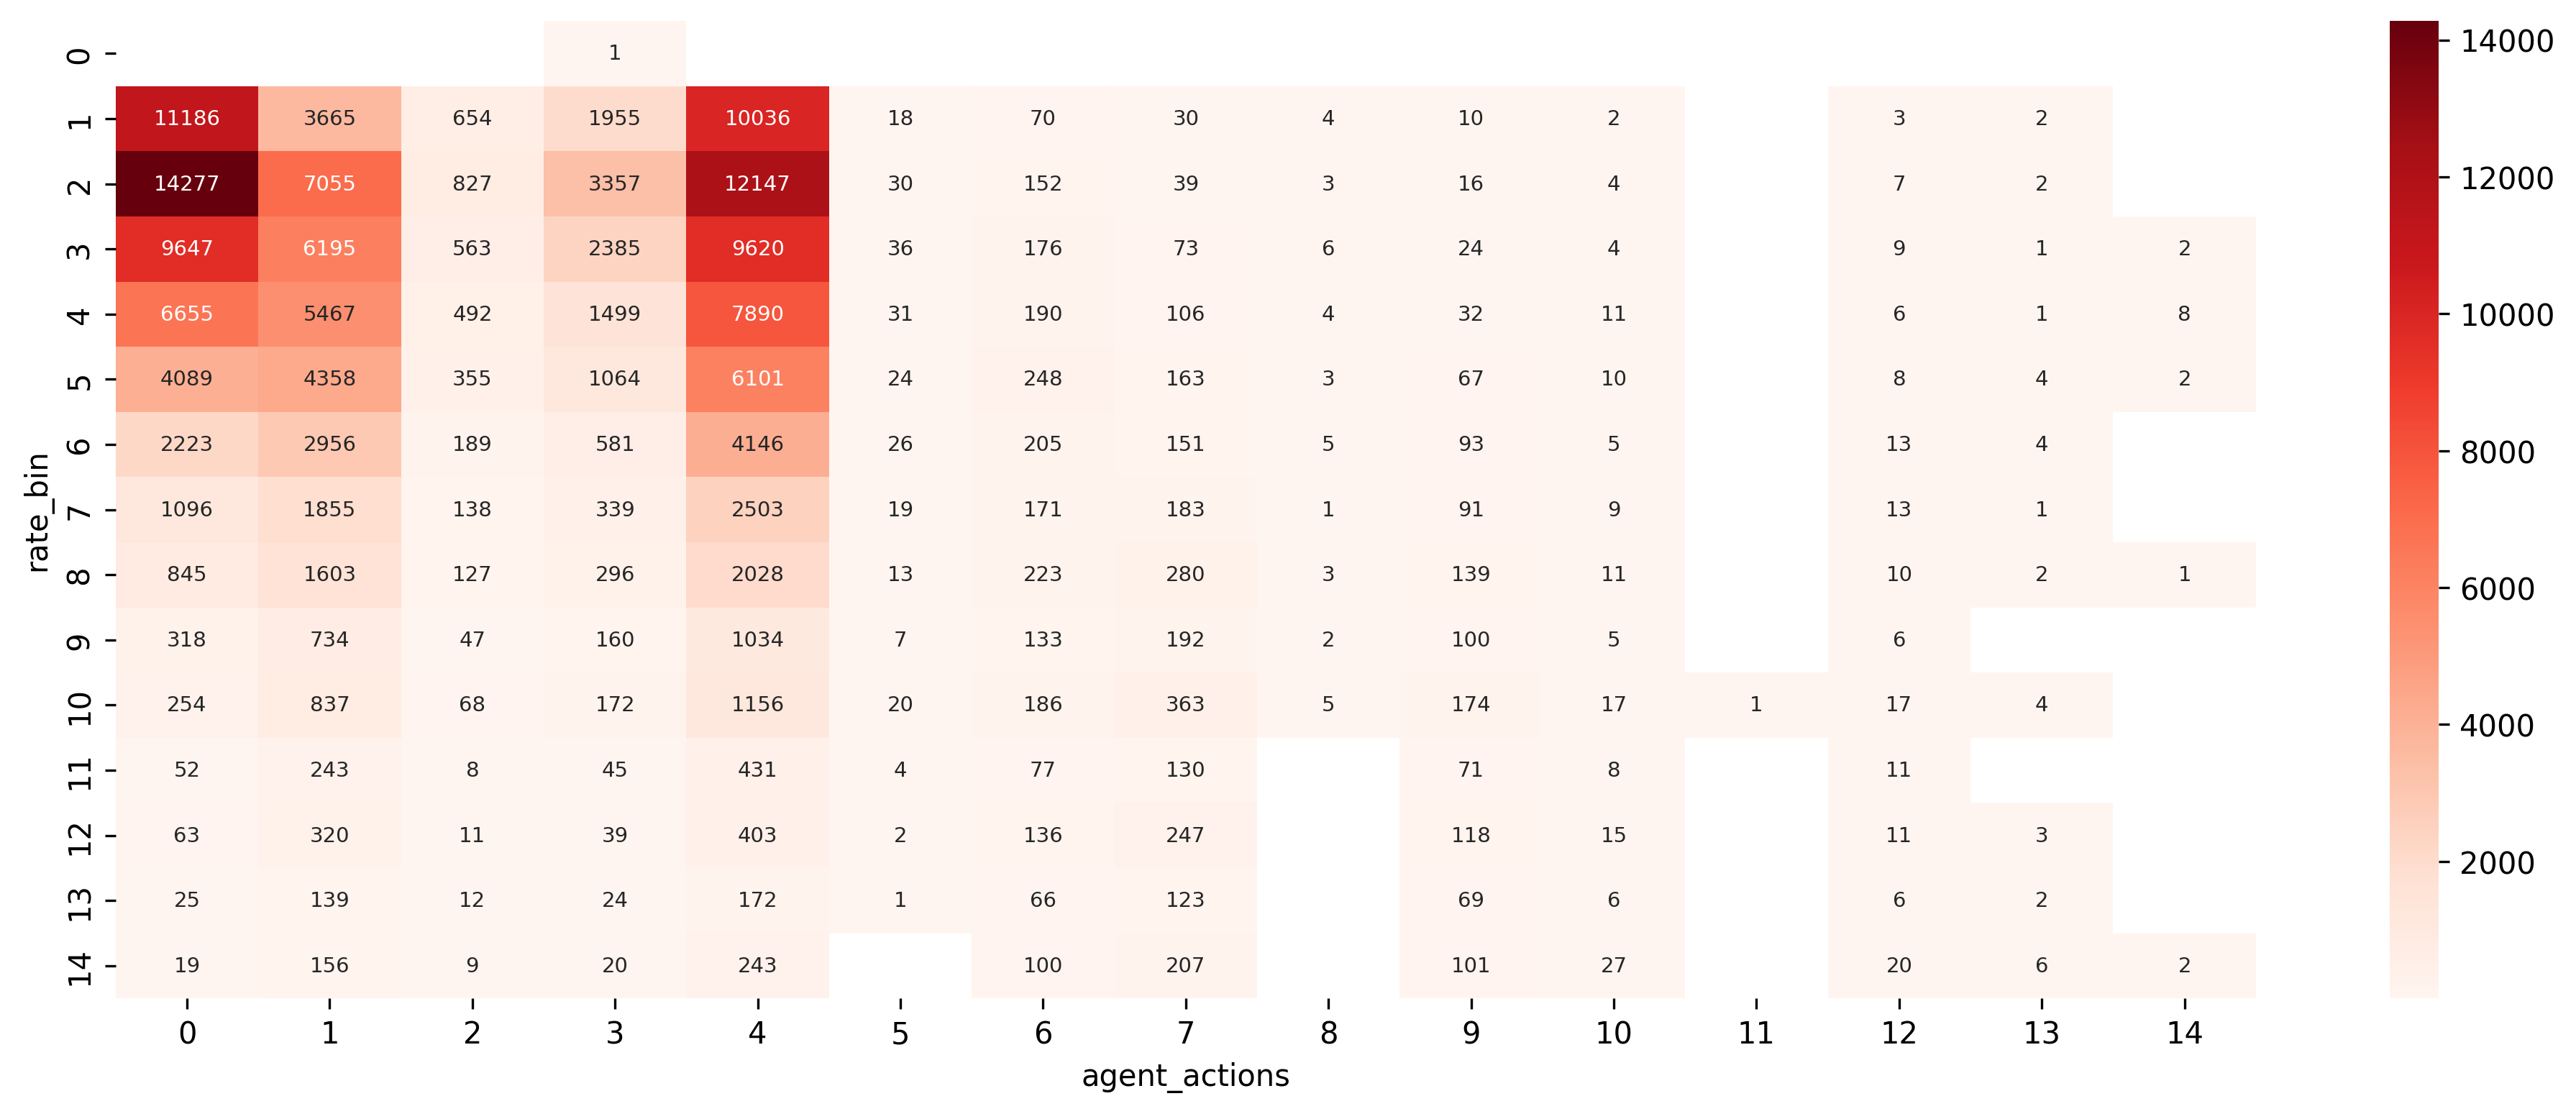

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df = df_eval_add2.loc[:,["rate_bin", "agent_actions"]]
df_count = df.value_counts().reset_index()
df_count = df_count.rename(columns={0:'value'})
df_count = df_count.pivot("rate_bin","agent_actions","value")
plt.figure(figsize=(16, 6),dpi=300)
sns.heatmap(df_count,cmap='Reds', annot=True, fmt='.5g',annot_kws={'size':7})

# D-Reward

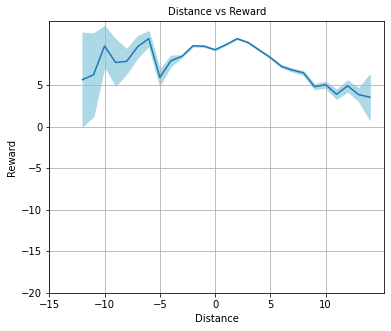

In [16]:
# 真实 - 推荐
df = df_eval_add2.loc[:,["distance","reward"]]

from scipy.stats import sem

bin_medians = []
bin_rewards_means = []
bin_rewards_stds = []
i = min(df.distance.unique())
while i <= max(df.distance.unique()):
    bin_df =df.loc[(df["distance"]>i-0.5) & (df["distance"]<i+0.5)]
    if len(bin_df) >= 2:
        bin_reward_mean = sum(bin_df['reward'])/float(len(bin_df))
        bin_medians.append(i)
        bin_rewards_means.append(bin_reward_mean)
        bin_rewards_stds.append(sem(bin_df['reward']))
    i += 1


plt.figure(figsize=(6, 5))
plt.plot(bin_medians, bin_rewards_means)
plt.fill_between(bin_medians, np.array(bin_rewards_means) - 1*np.array(bin_rewards_stds),  
                 np.array(bin_rewards_means) + 1*np.array(bin_rewards_stds), color='#ADD8E6')


plt.xticks(range(-15,15,5))
r = [float(i) for i in range(-20,10,5)]
_ = plt.yticks(r)
_ = plt.title("Distance vs Reward", fontsize=10)  
_ = plt.ylabel("Reward")
_ = plt.xlabel("Distance")
plt.grid()


(165793, 25) (354, 25) (23526, 25)


Text(0, 0.5, 'count')

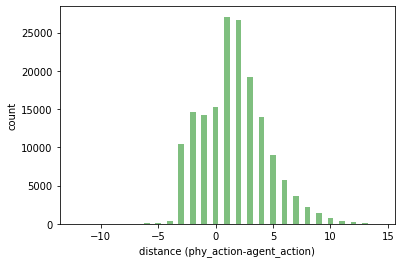

In [17]:
print(df_eval_add2.shape, df_eval_add2[df_eval_add2["distance"]<=-5].shape, df_eval_add2[df_eval_add2["distance"]>=5].shape)
tmp_df = pd.DataFrame(df_eval_add2["distance"].value_counts())
tmp_df = tmp_df.reset_index()

X=tmp_df["index"]
Y=tmp_df["distance"]
fig = plt.figure()
plt.bar(X,Y,0.5,color="green",alpha = 0.5)
plt.xlabel("distance (phy_action-agent_action)")
plt.ylabel("count")

In [18]:
stop!!!

SyntaxError: invalid syntax (<ipython-input-18-9a9c723360e0>, line 1)

In [ ]:
a_distance=10
tmp_df = df_eval_add2[df_eval_add2["distance"] > a_distance].loc[:,["reward", "glucose_mean", "glucose_max", "glucose_min", "agent_actions","rate_bin", "glu_bin"]]
print("distance >",a_distance,":", tmp_df.shape[0])
print(tmp_df.rate_bin.unique(), tmp_df.agent_actions.unique())
tmp_df.glu_bin.value_counts().head(15)

In [ ]:
a_distance=-5
tmp_df = df_eval_add2[df_eval_add2["distance"] < a_distance].loc[:,["reward","glu_bin", "glucose_mean", "glucose_max", "glucose_min", "agent_actions","rate_bin"]]
print("distance <",a_distance,":", tmp_df.shape[0])
print(tmp_df.rate_bin.unique(), tmp_df.agent_actions.unique())
tmp_df.glu_bin.value_counts().head(15)

# 4. 不同控糖状态两者的动作分布

In [ ]:
print(min(df_eval_add2["reward"]), max(df_eval_add2["reward"]))
df_eval_add2.loc[df_eval_add2["reward"]<-40, "reward"] = -40

In [ ]:
# reward 按1分bin
df = df_eval_add2
cut_point = [-40, -35, -30, -25, -20, -15, -10, -5, 0, 5, 10, 15,21]

max_v = max(df["reward"])
v_bin = {}

tmp_v = cut_point[0]
cut_point = cut_point[1:]
idx = 0
while tmp_v <= max_v:
    last_tmp_v = tmp_v
    tmp_v = cut_point[idx]
    v_bin[(last_tmp_v, tmp_v)] = idx
    idx += 1
print(v_bin)

v_bin2 ={}
lst = df["reward"].unique().tolist()
for i in lst:
    for keys in v_bin.keys():
        if (i >= keys[0]) & (i<keys[1]):
            v_bin2[i] = v_bin[keys]

df["reward_bin"] = df.reward.map(v_bin2)
df = df.sort_values(by=["traj_id", "stay_id", "starttime"])
df.index = pd.RangeIndex(len(df.index))

v_bin_reverse = {}
for i,j in v_bin.items():
    v_bin_reverse[j] = i
v_bin_reverse.values()

## 4.1 不同控糖类型医生与模型行为的比较

In [ ]:
df_ = df_eval_add2.loc[:,["reward", "agent_actions","rate_bin","steady_control","steady_type","fast_control","fast_type", "control_type", "glucose_mean", "glucose_max", "glucose_min","distance"]]
df_["control_type2"] = df_["steady_type"]
df_["control_type2"].fillna(df_["fast_type"], inplace=True)
df_ = df_[df_["control_type2"].isin(['TD', 'TT', 'HT', 'HMH', 'HH', 'TL', 'HL', 'TH'])]

In [ ]:
tmp_df = df_

data = []
for i in np.unique(tmp_df["rate_bin"]).tolist():
    temp = []
    for j in tmp_df.control_type2.unique():
        shape0 = tmp_df[(tmp_df["rate_bin"] == i) & (tmp_df["control_type2"] == j)].shape[0]
        temp.append(shape0)
    data.append(temp)
data = np.array(data).T

In [ ]:
xLabel = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0]

yLabel = tmp_df.control_type2.unique()
plt.figure(figsize=(24, 4),dpi=300)
sns.set(font_scale=0.8)
ax = sns.heatmap(data, cmap='Reds',annot=True, linewidths=0.05, linecolor="red", annot_kws={"size": 8}, fmt='.40g',)
ax.set_yticks(range(len(yLabel)))
ax.set_yticklabels(yLabel)
ax.set_xticks(range(len(xLabel)))
ax.set_xticklabels(xLabel)
plt.show()

In [ ]:
tmp_df = df_

data = []
for i in [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0]: # np.unique(df_eval_add2["agent_actions"]).tolist():
    temp = []
    for j in tmp_df.control_type2.unique():
        shape0 = tmp_df[(tmp_df["agent_actions"] == i) & (tmp_df["control_type2"] == j)].shape[0]
        temp.append(shape0)
    data.append(temp)
data = np.array(data).T

In [ ]:
xLabel = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0]

yLabel = tmp_df.control_type2.unique()
plt.figure(figsize=(24, 4),dpi=300)
sns.set(font_scale=0.8)
ax = sns.heatmap(data, cmap='Reds',annot=True, linewidths=0.05, linecolor="red", annot_kws={"size": 8}, fmt='.40g',)
ax.set_yticks(range(len(yLabel)))
ax.set_yticklabels(yLabel)
ax.set_xticks(range(len(xLabel)))
ax.set_xticklabels(xLabel)
plt.show()

In [ ]:
tmp_df = df_
tmp_df["distance"] = tmp_df["rate_bin"] - tmp_df["agent_actions"]

data = []
for i in np.unique(tmp_df["distance"]).tolist():
    temp = []
    for j in tmp_df.control_type2.unique():
        shape0 = tmp_df[(tmp_df["distance"] == i) & (tmp_df["control_type2"] == j)].shape[0]
        temp.append(shape0)
    data.append(temp)
data = np.array(data).T

In [ ]:
xLabel = np.unique(tmp_df["distance"]).tolist()
yLabel = tmp_df.control_type2.unique()
plt.figure(figsize=(24, 4),dpi=300)
sns.set(font_scale=0.8)
ax = sns.heatmap(data, cmap='Reds',annot=True, linewidths=0.05, linecolor="red", annot_kws={"size": 8}, fmt='.40g',)
ax.set_yticks(range(len(yLabel)))
ax.set_yticklabels(yLabel)
ax.set_xticks(range(len(xLabel)))
ax.set_xticklabels(xLabel)
plt.show()


# reward check

In [ ]:
sns.distplot(df_eval_add2[df_eval_add2["steady_type"].isin(["TD","TT"])]["reward"])

In [ ]:
sns.distplot(df_eval_add2[df_eval_add2["steady_type"].isin(["TH"])]["reward"])

In [ ]:
sns.distplot(df_eval_add2[df_eval_add2["steady_type"].isin(["TL"])]["reward"])

In [ ]:
sns.distplot(df_eval_add2[df_eval_add2["fast_type"].isin(["HL"])]["reward"])

In [ ]:
sns.distplot(df_eval_add2[df_eval_add2["fast_type"].isin(["HT"])]["reward"])

In [ ]:
sns.distplot(df_eval_add2[df_eval_add2["fast_type"].isin(["HH"])]["reward"])

In [ ]:
sns.distplot(df_eval_add2[df_eval_add2["fast_type"].isin(["HMH"])]["reward"])

## Q-reward

In [ ]:
df = df_eval_add2

from scipy.stats import sem

i = min(df["agent_q"]) - 5
bin_medians = []
bin_reward_means = []
bin_reward_std = []

while i <= max(df["agent_q"]):
    bin_df = df.loc[(df["agent_q"]>=i-1) & (df["agent_q"]<i+1)]
    
    if len(bin_df) >= 2:
        bin_reward_mean = sum(bin_df['reward'])/float(len(bin_df))
        bin_medians.append(i)
        bin_reward_means.append(bin_reward_mean)
        bin_reward_std.append(sem(bin_df['reward']))
    i += 2
    
plt.figure(figsize=(6, 4.5))
plt.plot(bin_medians, bin_reward_means)
plt.fill_between(bin_medians, np.array(bin_reward_means) - 1*np.array(bin_reward_std),  
                 np.array(bin_reward_means) + 1*np.array(bin_reward_std), color='#ADD8E6')
plt.grid()
plt.xticks(range(-24,0,4))
r = [float(i) for i in range(-20,20,5)]
_ = plt.yticks(r)
_ = plt.title("Q vs Expected Return", fontsize=15)  
_ = plt.ylabel("Reward")
_ = plt.xlabel("Q - value")


## 不同控糖状态下，action的分布，match percent
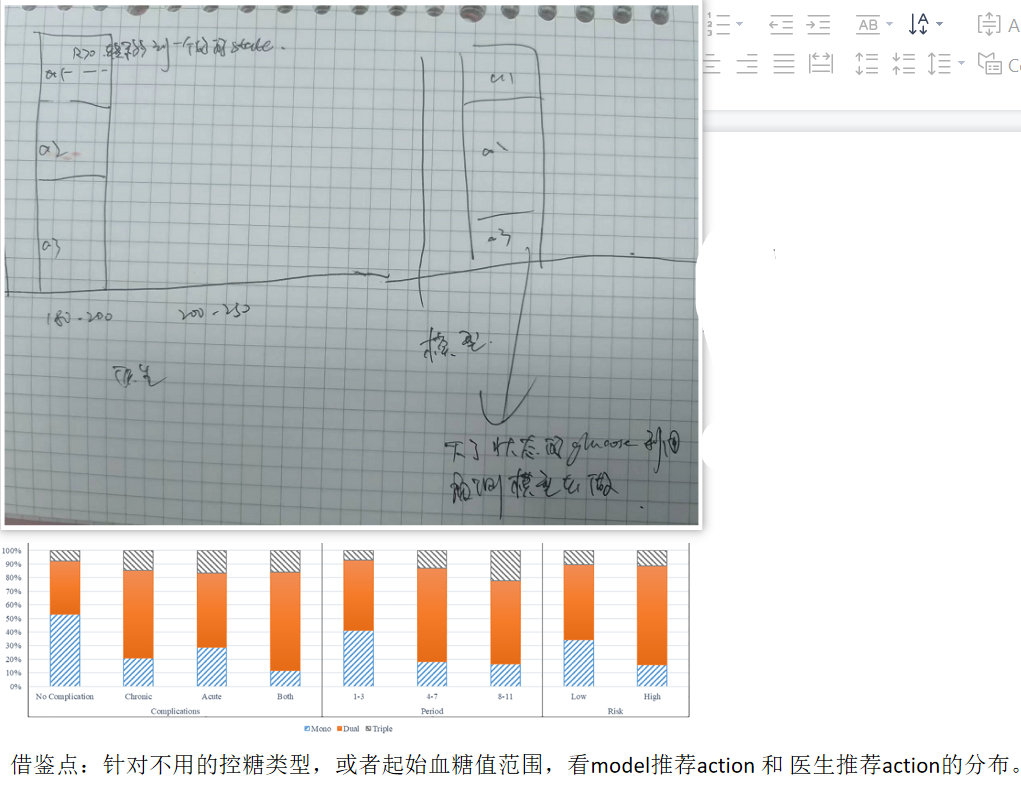

In [ ]:
'''df = df_eval_add

cut_point = [0, 72, 144, 216, 288, 360, 432, 1500]
max_glu = max(df["glucose_mean"])
glu_bin = {}

tmp_glu = cut_point[0]
cut_point = cut_point[1:]
idx = 0
while tmp_glu <= max_glu:
    last_tmp_glu = tmp_glu
    tmp_glu = cut_point[idx]
    glu_bin[(last_tmp_glu, tmp_glu)] = idx
    idx += 1
print(glu_bin)

glu_bin2 ={}
lst = df["glucose_mean"].unique().tolist()
for i in lst:
    for keys in glu_bin.keys():
        if (i >= keys[0]) & (i<keys[1]):
            glu_bin2[i] = glu_bin[keys]

df["glucose_bin"] = df.glucose_mean.map(glu_bin2)
df = df.sort_values(by=["traj_id", "stay_id", "starttime"])
df.index = pd.RangeIndex(len(df.index))'''

In [ ]:
'''switch = "on"
for i, j in df.groupby("glucose_bin"):
    print(i,j.shape[0])
    if switch == "on":
        jj = pd.DataFrame(j.rate_bin.value_counts()).head()
        jj.columns = [i]
        tmp_df = jj
        switch = "off"
    else:
        jj = pd.DataFrame(j.rate_bin.value_counts()).head()
        jj.columns = [i]
        tmp_df = pd.concat([jj,tmp_df],axis=1)
tmp_df.T'''

In [ ]:
'''# 模型推荐action与指南的比较， 横轴是模型的rate_bin, 纵轴是七种状态
switch = "on"
for i, j in df.groupby("glucose_bin"):
    print(i,j.shape)
    if switch == "on":
        jj = pd.DataFrame(j.agent_actions.value_counts()).head()
        jj.columns = [i]
        tmp_df = jj
        switch = "off"
    else:
        jj = pd.DataFrame(j.agent_actions.value_counts()).head()
        jj.columns = [i]
        tmp_df = pd.concat([jj,tmp_df],axis=1)
tmp_df.T'''

## 医生行为与模型行为下各事件的发生率, 在不同的控糖状态下
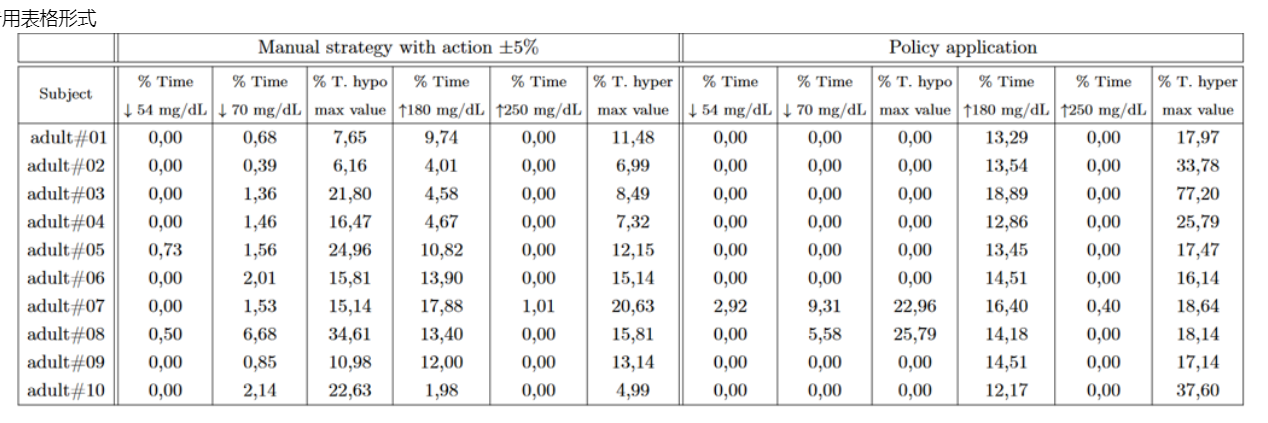
以state中的glucose的平均值来统计，状态转移的数量

# plot insulin+glucose by a traj（医生+模型推荐）
- 绘制真实血糖（每小时的平均值，最大最小值构成一个区间），医生和模型的action

In [ ]:
from mpl_toolkits.axisartist.parasite_axes import HostAxes, ParasiteAxes
import matplotlib.pyplot as plt
import numpy as np
from random import choice

df = df_eval_add2
df.head(2)

In [ ]:
ran_samp = choice(df["traj_id"].tolist())
#ran_samp = 5
print(ran_samp) # 10008   13051

glu_max = df[df["traj_id"]==ran_samp]["glucose_max"]
glu_min = df[df["traj_id"]==ran_samp]["glucose_min"]
glu_mean = df[df["traj_id"]==ran_samp]["glucose_mean"]
t_median = [ round((t+30)/60,2) for t in df[df["traj_id"]==ran_samp]["starttime"]]
agent_ac = df[df["traj_id"]==ran_samp]["agent_actions"]
phys_ac = df[df["traj_id"]==ran_samp]["rate_bin"]
real_ac = df[df["traj_id"]==ran_samp]["rate"]

fig = plt.figure(1) #定义figure，（1）中的1是什么
ax_cof = HostAxes(fig, [0, 0, 0.9, 0.9])  #用[left, bottom, weight, height]的方式定义axes，0 <= l,b,w,h <= 1

#parasite addtional axes, share x
ax_agent_ac = ParasiteAxes(ax_cof, sharex=ax_cof)
ax_phy_ac = ParasiteAxes(ax_cof, sharex=ax_cof)
ax_real_ac = ParasiteAxes(ax_cof, sharex=ax_cof)

ax_cof.parasites.append(ax_agent_ac)
ax_cof.parasites.append(ax_phy_ac)
ax_cof.parasites.append(ax_real_ac)

ax_cof.axis['right'].set_visible(False)
ax_cof.axis['top'].set_visible(False)
ax_real_ac.axis['right'].set_visible(True)
ax_real_ac.axis['right'].major_ticklabels.set_visible(True)
ax_real_ac.axis['right'].label.set_visible(True)

#set label for axis
ax_cof.set_ylabel('glucose')
ax_cof.set_xlabel('Hours into the ICU')
ax_agent_ac.set_ylabel('agent_action_bin')
ax_phy_ac.set_ylabel('phy_action_bin')
ax_real_ac.set_ylabel('phy_action_real')

agent_ac_axisline = ax_agent_ac.get_grid_helper().new_fixed_axis
phy_ac_axisline = ax_phy_ac.get_grid_helper().new_fixed_axis
real_ac_axisline = ax_real_ac.get_grid_helper().new_fixed_axis

ax_real_ac.axis['right'] = real_ac_axisline(loc='right', axes=ax_real_ac, offset=(0,0))
ax_agent_ac.axis['right2'] = agent_ac_axisline(loc='right', axes=ax_agent_ac, offset=(40,0))
ax_phy_ac.axis['right3'] = phy_ac_axisline(loc='right', axes=ax_phy_ac, offset=(80,0))

fig.add_axes(ax_cof)

curve_cof, = ax_cof.plot(t_median, glu_mean, label="glucose", color='black', marker='o',ms=5)
plt.fill_between(t_median, glu_min,  
                 glu_max, color='#636363')
curve_real_ac, = ax_real_ac.plot(t_median, real_ac, label="real_ac", color='#756bb1', marker='o',ms=4)
curve_agent_ac, = ax_agent_ac.plot(t_median, agent_ac, label="agent_ac_bin", color='green', marker='o',ms=4)
curve_phy_ac, = ax_phy_ac.plot(t_median, phys_ac, label="phys_ac_bin", color='pink', marker='o',ms=4)

#ax_cof.set_ylim(0,max(glu_max)+50)
ax_cof.set_ylim(0,300)
ax_agent_ac.set_ylim(0,15)
ax_phy_ac.set_ylim(0,15)
ax_real_ac.set_ylim(0,15)

ax_cof.legend()

ax_real_ac.axis['right'].label.set_color('#756bb1')
ax_agent_ac.axis['right2'].label.set_color('green')
ax_phy_ac.axis['right3'].label.set_color('pink')

ax_real_ac.axis['right'].major_ticks.set_color('#756bb1')
ax_agent_ac.axis['right2'].major_ticks.set_color('green')
ax_phy_ac.axis['right3'].major_ticks.set_color('pink')

ax_real_ac.axis['right'].major_ticklabels.set_color('#756bb1')
ax_agent_ac.axis['right2'].major_ticklabels.set_color('green')
ax_phy_ac.axis['right3'].major_ticklabels.set_color('pink')

ax_real_ac.axis['right'].major_ticklabels.set_color('#756bb1')
ax_agent_ac.axis['right2'].line.set_color('green')
ax_phy_ac.axis['right3'].line.set_color('pink')

plt.axhline(180, color='grey', lw=2, linestyle='--',alpha=0.7)
plt.axhline(70, color='grey', lw=2,linestyle='--', alpha=0.7)


In [ ]:
# 8267, 6535, 8997

# tans time caluculation by traj
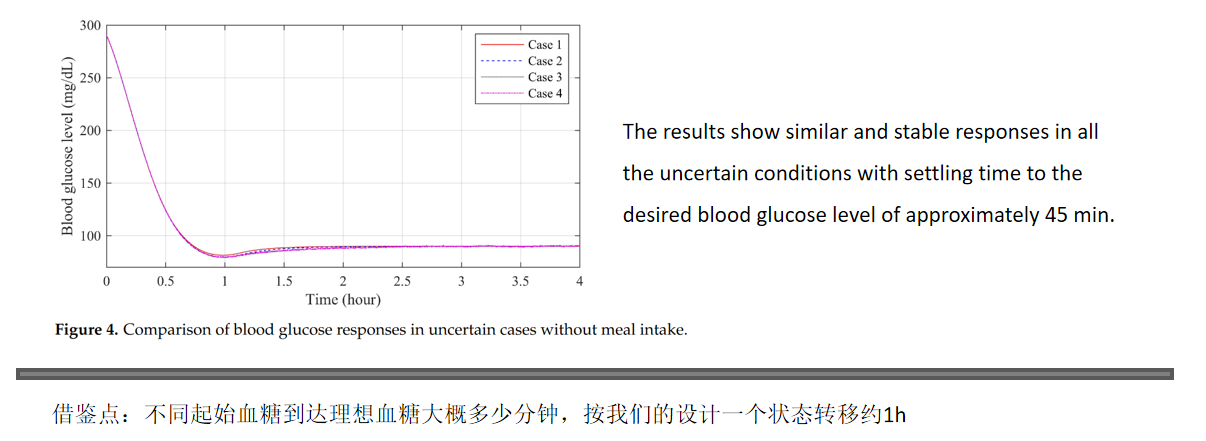

- 定位所有高血糖的状态，分析不同状态下平均多少个状态转移到正常状态

In [ ]:
'''df = df_eval_add

cut_point = [0, 72, 180, 216, 288, 360, 432, 1500]
max_glu = max(df["glucose_mean"])
glu_bin = {}

tmp_glu = cut_point[0]
cut_point = cut_point[1:]
idx = 0
while tmp_glu <= max_glu:
    last_tmp_glu = tmp_glu
    tmp_glu = cut_point[idx]
    glu_bin[(last_tmp_glu, tmp_glu)] = idx
    idx += 1
print(glu_bin)

glu_bin2 ={}
lst = df["glucose_mean"].unique().tolist()
for i in lst:
    for keys in glu_bin.keys():
        if (i >= keys[0]) & (i<keys[1]):
            glu_bin2[i] = glu_bin[keys]

df["glucose_bin"] = df.glucose_mean.map(glu_bin2)
df = df.sort_values(by=["traj_id", "stay_id", "starttime"])
df.index = pd.RangeIndex(len(df.index))
'''

In [ ]:
'''trans_dict = {}
df = df.sort_values(by=["traj_id","starttime"])
df['idx'] = range(len(df))

iternum = 0
while iternum < 1000:
    ran_idx = choice(df[df["glucose_bin"].isin([2,3,4,5,6])]["idx"].tolist())
    traj_id = df[df["idx"]==ran_idx]["traj_id"].tolist()[0]

    st = df[df["idx"]==ran_idx]["glucose_bin"].tolist()[0]
    if df.loc[(df["traj_id"]==traj_id) & (df["idx"]>ran_idx) & (df["glucose_bin"]==1)]["idx"].shape[0] > 0:
        trans_num = df.loc[(df["traj_id"]==traj_id) & (df["idx"]>ran_idx) & (df["glucose_bin"]==1)]["idx"].tolist()[0] - ran_idx
    else:
        trans_num = 0
    
    if st not in trans_dict.keys():
        trans_dict[st] = []
    else:
        trans_dict[st].append(trans_num)
    iternum += 1'''

In [ ]:
'''for i,j in trans_dict.items():
    unique, counts = np.unique(j, return_counts=True)
    print(i, np.asarray((unique, counts)))
# 基本1，2，3，4步可以转移到正常血糖范围'''

## Q 箱型图

In [ ]:
'''import pickle
import pandas as pd

def my_save(List,filename,Global):
    # filename : name.pkl
    my_pickle = {}
    for key in List:
        try:
            my_pickle[key] = Global[key] #globals()[key]
        except TypeError:
            print('ERROR pickleing: {0}'.format(key))
    with open(filename, 'wb') as f:   # Python 3: open(..., 'wb')
        pickle.dump(my_pickle, f)


def my_load(filename,Global):
    with open(filename, 'rb') as f:  # Python 3: open(..., 'rb')
        my_shelf = pickle.load(f)

    for key in my_shelf:
        Global[key] = my_shelf[key]

filename = r'model_convergence.pkl'
my_load(save_dir +filename, globals())

from matplotlib import pyplot as plt
plt.boxplot((av_agent_q_lst,av_phys_q_lst),labels=('agent_q','av_phys_q'))
plt.show()'''